# Mount Google Drive in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install necessary packages

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow scikit-learn matplotlib

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.models import Model, Sequential, load_model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from efficientnet.tfkeras import EfficientNetB0
from keras.utils import plot_model
from keras.layers import BatchNormalization, LeakyReLU

# Define paths and constants

In [ ]:
data_dir = '/content/drive/MyDrive/ISIC_Labelled'
test_data_dir = '/content/drive/MyDrive/test_dataset'

input_shape = (300, 300, 3)
num_classes = 8
epochs = 30
batch_size = 32

# Data preprocessing and augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

Found 8541 images belonging to 8 classes.
Found 8541 images belonging to 8 classes.
Found 1849 images belonging to 8 classes.


# Define EfficientNet model

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300, 300, 3), classes=8)

16804768/16804768 [==============================] - 0s 0us/step


# Define custom model

In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Increased dropout rate for better regularization
    Dense(1024),
    BatchNormalization(),  # Adding Batch Normalization
    LeakyReLU(),  # Using Leaky ReLU activation function
    Dropout(0.5),
    Dense(512),  # Additional Dense layer
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

# View Model Summary & Plot

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 10, 10, 1280)      4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                        

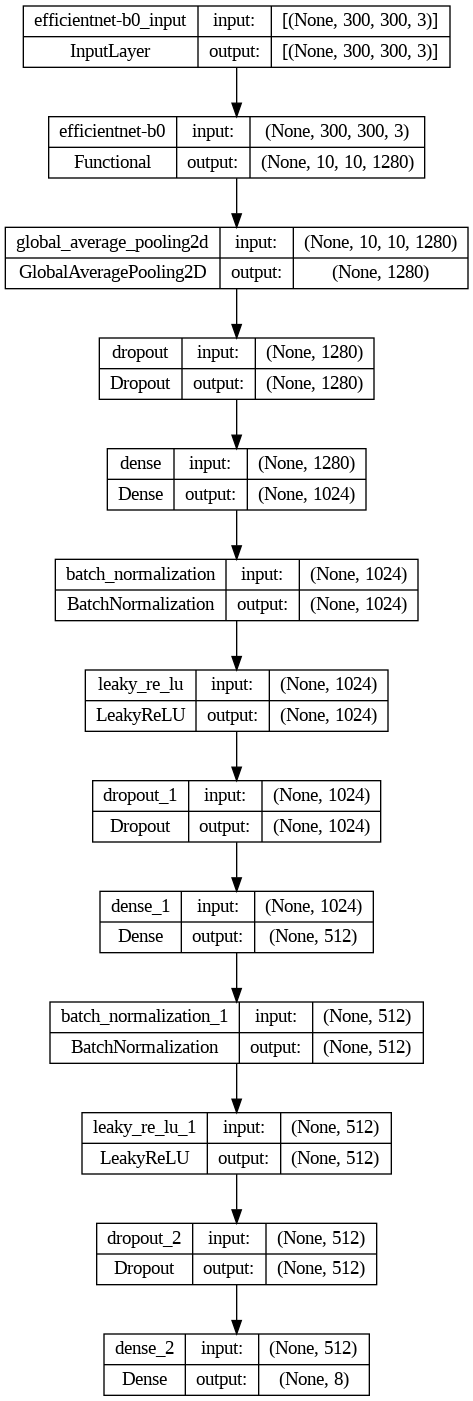

In [ ]:
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

# Define optimizer, learning rate scheduler, and early stopping

In [ ]:
optimizer = Adam(learning_rate=0.0001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Compile & Train the model

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/30
266/266 [==============================] - 7231s 27s/step - loss: 1.9625 - accuracy: 0.3722 - val_loss: 1.7162 - val_accuracy: 0.4206 - lr: 1.0000e-04
Epoch 2/30
266/266 [==============================] - 7116s 27s/step - loss: 1.5074 - accuracy: 0.5077 - val_loss: 1.0480 - val_accuracy: 0.6380 - lr: 1.0000e-04
Epoch 3/30
266/266 [==============================] - 7263s 27s/step - loss: 1.3037 - accuracy: 0.5614 - val_loss: 0.8899 - val_accuracy: 0.6855 - lr: 1.0000e-04
Epoch 4/30
266/266 [==============================] - 7043s 26s/step - loss: 1.1517 - accuracy: 0.5992 - val_loss: 0.7674 - val_accuracy: 0.7330 - lr: 1.0000e-04
Epoch 5/30
181/266 [===================>..........] - ETA: 29:33 - loss: 1.0785 - accuracy: 0.6291

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ISIC_Labelled -4GB/Basal cell carcinoma/ISIC_0064128.jpg'
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ISIC_Labelled -4GB/Basal cell carcinoma/ISIC_0064128.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_33068]

# Training time

In [ ]:
total_time = training_time / 60
time_per_epoch = total_time / epochs
print(f"Time per epoch: {time_per_epoch} minutes")
print(f"Total time for training: {total_time} minutes")

# Calculate the Loss and Accuracy on the Validation Data

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('test accuracy : ', test_acc)

# Saving the model prediction on a csv file

In [ ]:
# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get filenames and true labels from the test generator
filenames = test_generator.filenames
true_classes = test_generator.classes

# Creating a DataFrame with filenames, true labels, and predicted labels
results_df = pd.DataFrame({'Filename': filenames,
                           'True Class': true_classes,
                           'Predicted Class': predicted_classes})

# Saving the DataFrame to a CSV file
results_df.to_csv('/content/drive/MyDrive/test_dataset/test_predictions.csv', index=False)

print("Model predictions saved successfully.")

# Model Evaluation

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy & Loss

In [ ]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Classification Report

In [ ]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Correlation Heatmap

In [ ]:
corr = np.corrcoef(predictions.T)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classes')
plt.ylabel('Classes')
plt.title('Correlation Heatmap of Classes')
plt.show()